In [1]:
import matplotlib.pyplot as plt
import csv
import numpy as np
import re
import datetime

In [2]:
"""Used the following website to help with reading CSV files: 
https://www.geeksforgeeks.org/python/how-to-read-from-a-file-in-python/"""

#getting quaternino data from first IMU sensor

with open("Experiment VauxWall Data Final/Quaternion Data/id_4_t2/Quaternion_1.csv", newline='') as csvfile:

    csvreader = csv.reader(csvfile, delimiter='\t')
    sensor1 = []
    for row in csvreader:
        sensor1.append(row)

#only getting from the third row onwards (first rows are header, serial number etc.)    
sensor_1_clean_data = sensor1[3:]

print(len(sensor_1_clean_data))

1540


In [3]:
#getting quaternion data from second IMU sensor

with open("Experiment VauxWall Data Final/Quaternion Data/id_4_t2/Quaternion_2.csv", newline='') as csvfile:

    csvreader = csv.reader(csvfile, delimiter='\t')
    sensor2 = []
    for row in csvreader:
        sensor2.append(row)
        
sensor_2_clean_data = sensor2[3:]

print(sensor_2_clean_data)
print(len(sensor_2_clean_data))

[['09/06/2025 17:40:51.946', '0.79614365', '-0.45653403', '-0.2727408', '-0.28911892', 'None'], ['09/06/2025 17:40:51.956', '0.79523474', '-0.45772097', '-0.2712561', '-0.29113334', 'None'], ['09/06/2025 17:40:51.966', '0.7945256', '-0.45843777', '-0.270197', '-0.292921', 'None'], ['09/06/2025 17:40:51.976', '0.79416126', '-0.45844194', '-0.26971897', '-0.29434037', 'None'], ['09/06/2025 17:40:51.986', '0.7942631', '-0.4575669', '-0.26979992', '-0.29535103', 'None'], ['09/06/2025 17:40:51.996', '0.7948559', '-0.45576206', '-0.2704694', '-0.29593426', 'None'], ['09/06/2025 17:40:52.006', '0.79582816', '-0.45321319', '-0.27167624', '-0.29613048', 'None'], ['09/06/2025 17:40:52.016', '0.79692096', '-0.45033854', '-0.27327207', '-0.2961086', 'None'], ['09/06/2025 17:40:52.026', '0.7979287', '-0.44751063', '-0.27502713', '-0.29605713', 'None'], ['09/06/2025 17:40:52.036', '0.79873574', '-0.4449065', '-0.27682865', '-0.29612646', 'None'], ['09/06/2025 17:40:52.046', '0.7994599', '-0.4425648'

In [4]:
#function for multiplying two quaternions
def multiply_quaternions(q1,q2):
    w1,x1,y1,z1 = q1
    w2,x2,y2,z2 = q2

    return[
        w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2, 
        w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2,
        w1 * y2 - x1 * z2 + y1 * w2 + z1 * x2,
        w1 * z2 + x1 * y2 - y1 * x2 + z1 * w2
    ]

def quaternion_to_angle(sensor_array_1, sensor_array_2):

    angles_from_quaternions = []
    counter = 0

    for i in sensor_array_1:
        w1,x1,y1,z1 = float(i[1]), float(i[2]),float(i[3]), float(i[4])
        q1_conjugate = [w1, -x1, -y1, -z1]
        angle_calculated = False
          
        while angle_calculated == False and counter <len(sensor_array_2):
            k = sensor_array_2[counter]
            w2,x2,y2,z2 = float(k[1]), float(k[2]), float(k[3]), float(k[4])
            q2 = [w2, x2,y2,z2]

            #q_relative is the conjugate * q2
            q_relative = multiply_quaternions(q2, q1_conjugate) 
            
            #calculating angle from q_relative
            theta = 2 * np.arccos(q_relative[0])
            theta_deg = theta * (180/np.pi)

            angles_from_quaternions.append([theta_deg - 180] + [k[0]]) #180 - theta because sensors were inverted i think
            counter+=1
            angle_calculated = True
    
    
    return angles_from_quaternions


In [5]:
angles_with_timestamps = quaternion_to_angle(sensor_2_clean_data, sensor_1_clean_data)

angles = []
timestamps = []

for i in angles_with_timestamps:
    angles.append(i[0])
    timestamps.append(i[1])

In [6]:
#function to get the visibility value from a Landmark string from CSV file
def get_visibility(landmark):
    visibility = re.search(r'visibility=([0-9.]+)', landmark)
    vis_value = visibility.group(1)
    return float(vis_value)

In [7]:
#Retrieving angles from CV results
with open("Experiment VauxWall Data Final/id_4_t2.csv", newline='') as csvfile:

    csvreader = csv.reader(csvfile)

    computer_vision_results = []

    added_frames = 0
    total_frames = 0

    for row in csvreader:
        

        try:
            
            #getting the landmarks of shoulder, elbow, wrist (in string)
            shoulder_landmark = row[-24]
            elbow_landmark = row[-22]
            wrist_landmark = row[-20]

            #getting the visibility value of each landmark
            vis_shoulder = get_visibility(shoulder_landmark)
            vis_elbow = get_visibility(elbow_landmark)
            vis_wrist = get_visibility(wrist_landmark)
           
            
            #only adding the angles from CV results that are inbetween the time stamps of the quaternion data
            if datetime.datetime.strptime(row[0], '%Y-%m-%d %H:%M:%S.%f') > datetime.datetime.strptime(timestamps[0], '%m/%d/%Y %H:%M:%S.%f') and datetime.datetime.strptime(row[0], '%Y-%m-%d %H:%M:%S.%f') < datetime.datetime.strptime(timestamps[-1], '%m/%d/%Y %H:%M:%S.%f'):
                total_frames +=1
                #if visbility value of shoulder, elbow and wrist are above threshold, then add the data points
                if vis_shoulder > 0.5 and vis_elbow > 0.5 and vis_wrist > 0.5:
                    added_frames += 1
                    computer_vision_results.append([row[-3]] + [row[0]]) #the third last column is angle, first column is timestamp
                else:
                    pass
            else:
                pass
        except:
            pass
    
    print("total frames", total_frames)
    print("added frames", added_frames)
    print("dropped frames", (total_frames - added_frames))
    print("dropped frames percentage",(total_frames - added_frames) / total_frames )

total frames 461
added frames 15
dropped frames 446
dropped frames percentage 0.9674620390455532


In [ ]:
CV_angles = []
CV_time_stamps = []
for i in computer_vision_results:
    CV_angles.append(float(i[0]))
    CV_time_stamps.append(i[1])

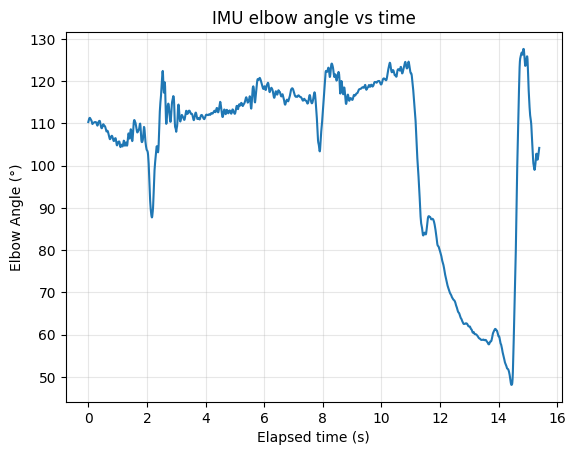

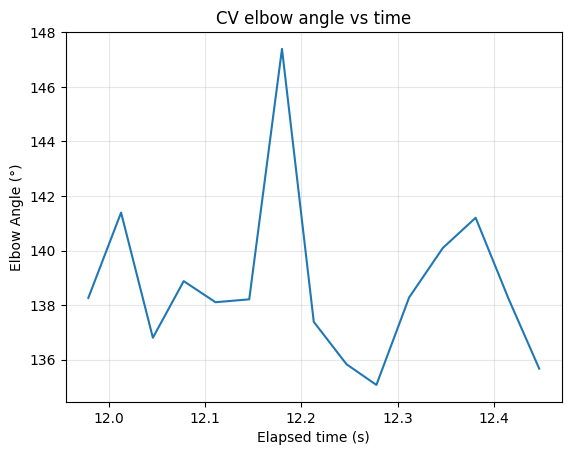

In [9]:
#converting IMU sensor and CV sensor timestamps into datetime format

#CV timestamps into datetime
CV_time_stamps_datetime = []

for i in CV_time_stamps:
    date_time = datetime.datetime.strptime(i, "%Y-%m-%d %H:%M:%S.%f")
    CV_time_stamps_datetime.append(date_time)

#IMU timestamps into datetime
IMU_time_stamps_datetime = []

for i in timestamps:
    date_time = datetime.datetime.strptime(i, "%m/%d/%Y %H:%M:%S.%f")
    IMU_time_stamps_datetime.append(date_time)




#calculating relative time for CV and IMU timestamps

t0 = IMU_time_stamps_datetime[0] #t0 will be the first timestamp from the IMU sensor (ground truth)

relative_time_CV = [] 
for i in CV_time_stamps_datetime:
    rel_time = i - t0
    relative_time_CV.append(rel_time.total_seconds())

relative_time_IMU = []
for i in IMU_time_stamps_datetime:
    rel_time = i - t0
    relative_time_IMU.append(rel_time.total_seconds())


#plot of relative time IMU
plt.plot(relative_time_IMU, angles)
plt.xlabel("Elapsed time (s)")
plt.ylabel("Elbow Angle (°)")
plt.title("IMU elbow angle vs time")
plt.grid(alpha=0.3)
plt.show()

#plot of relative time CV
plt.plot(relative_time_CV, CV_angles)
plt.xlabel("Elapsed time (s)")
plt.ylabel("Elbow Angle (°)")
plt.title("CV elbow angle vs time")
plt.grid(alpha=0.3)
plt.show()

In [10]:
#generate Guassian Kernel
import math 

def guassian_kernel_generator(kernel_size, sigma):
    half = kernel_size // 2
    values = [index for index in range(0 - half , 0 + half + 1)]

    gaussian_values = []

    for i in values: 
        value = math.exp((-i**2)/(2*sigma**2))
        gaussian_values.append(value)
    
    norm_gaussian_values = []
    for i in gaussian_values:
        value = i / sum(gaussian_values)
        norm_gaussian_values.append(value)
    
    return norm_gaussian_values

In [11]:
def calculate_angles_and_reweighted_window(angles, weighted_window, lower_bound, upper_bound):
    weighted_average = []
    angles_to_avg = angles[lower_bound: upper_bound]
    
    if lower_bound == 0:
        for missing_angle in range(0,len(weighted_window)- len(angles_to_avg)):
                angles_to_avg.insert(0,angles[0])
    else:
        for missing_angle in range(0,len(weighted_window)- len(angles_to_avg)):
                angles_to_avg.append(angles[-1])
    
    for j in range(0, len(angles_to_avg)):
                weighted_angle = angles_to_avg[j] * weighted_window[j]
                weighted_average.append(weighted_angle)
                
    return weighted_average

In [12]:
def weighted_convolution(angles, weighted_window):
    
    smoothed_signal = []
    half = len(weighted_window) // 2 #go up and down by half to keep convolution in the middle

    for i in range(0, len(angles)):

        #check if out of bounds (below 0)
        if i - half < 0: 
          
            weighted_average = calculate_angles_and_reweighted_window(angles,weighted_window, 0, i + half + 1)
            smoothed_signal.append(sum(weighted_average))
        
        #check if out of bound (above last index)
        elif i + half  > len(angles) - 1:
            
            weighted_average = calculate_angles_and_reweighted_window(angles, weighted_window, i - half, i + half + 1)
            smoothed_signal.append(sum(weighted_average))
        
        else:

            weighted_average = calculate_angles_and_reweighted_window(angles, weighted_window, i - half, i + half + 1)
            smoothed_signal.append(sum(weighted_average))
    
    return smoothed_signal

[0.32953142087081966, 0.3409371582583608, 0.32953142087081966]


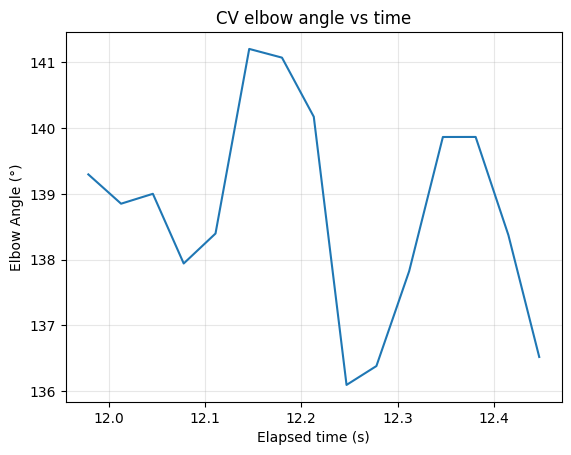

In [13]:
#creating a gaussian kernel to pass into weighted convolution function
gaussian_kernel = guassian_kernel_generator(3, 23/6) #changed from 23 in sanity to 13 

print(gaussian_kernel)

cv_angle_guassian_smooth = weighted_convolution(CV_angles,gaussian_kernel)

plt.plot(relative_time_CV, cv_angle_guassian_smooth)
plt.xlabel("Elapsed time (s)")
plt.ylabel("Elbow Angle (°)")
plt.title("CV elbow angle vs time")
plt.grid(alpha=0.3)
plt.show()

MAE before convolution is: 33.87092350191672


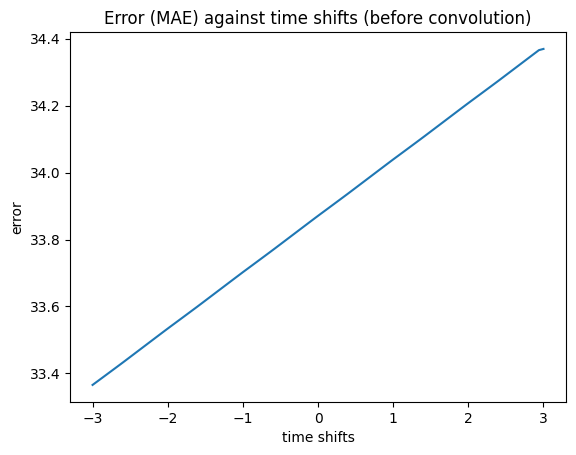

MAE after convolution is: 34.832841361798025


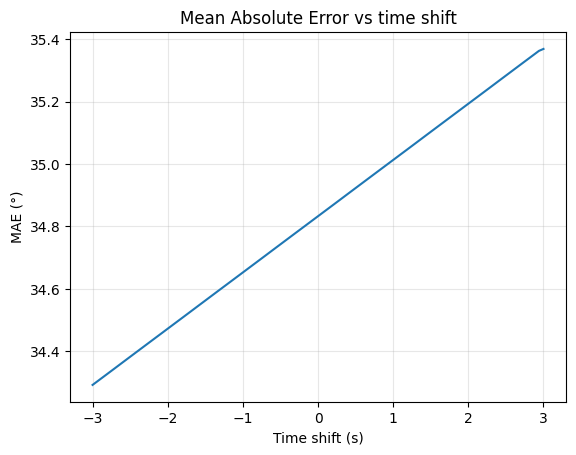

In [14]:
"""CV angles interpolated on IMU time axis. Each angle coincides with a relative 
time frame from IMU time axis"""

#Calculating MAE of time shift 0 (original time)
CV_interp = np.interp(relative_time_IMU, relative_time_CV, CV_angles)
absolute_error = sum(abs(CV_interp - angles))
MAE = absolute_error / len(relative_time_IMU)
print("MAE before convolution is:", MAE)

def time_shift_errors(lower_bound, upper_bound, number_of_samples, cv_angles):
    #time shift
    time_shifts = np.linspace(lower_bound,upper_bound,number_of_samples)

    MAE_time_shifts = []
    errors_seperated = []
    time_shifts_seperated = []

    for i in time_shifts:
    
        #add time shift to each time value
        time_shifted = [i + time for time in relative_time_CV]
        
        #intersection time range where both have data
        time_shifted_intersection = [time for time in time_shifted 
                                    if time > relative_time_IMU[0] and time < relative_time_IMU[-1]]
        
        #intersection angle range where both have data
        CV_angles_trimmed = [angle for time, angle in zip(time_shifted, cv_angles) 
        if time > relative_time_IMU[0] and time < relative_time_IMU[-1]]

        #interpolate computer vision angle and time onto IMU time
        CV_interp = np.interp(relative_time_IMU, time_shifted_intersection, CV_angles_trimmed)
        
        absolute_error = sum((abs(CV_interp - angles)))
        MAE = absolute_error / len(relative_time_IMU) 


        MAE_time_shifts.append([MAE, i])
        errors_seperated.append(MAE)
        time_shifts_seperated.append(i)
    
    return MAE_time_shifts, errors_seperated, time_shifts_seperated


#getting time shifts and errors into seperate arrays from MAE_time_shifts array
MAE_Total, errors_seperated, time_shifts_seperated = time_shift_errors(-3,3,100,CV_angles)

plt.plot(time_shifts_seperated, errors_seperated)
plt.title("Error (MAE) against time shifts (before convolution)")
plt.xlabel("time shifts")
plt.ylabel("error")
plt.show()

CV_interp = np.interp(relative_time_IMU, relative_time_CV, cv_angle_guassian_smooth)
absolute_error = sum(abs(CV_interp - angles))
MAE = absolute_error / len(relative_time_IMU)
print("MAE after convolution is:", MAE)

MAE_Total, errors_seperated, time_shifts_seperated = time_shift_errors(-3,3,100, cv_angle_guassian_smooth)
#getting time shifts and errors into seperate arrays from MAE_time_shifts array

plt.plot(time_shifts_seperated, errors_seperated)
plt.title("Mean Absolute Error vs time shift")
plt.xlabel("Time shift (s)")
plt.ylabel("MAE (°)")
plt.grid(alpha=0.3)
plt.show()

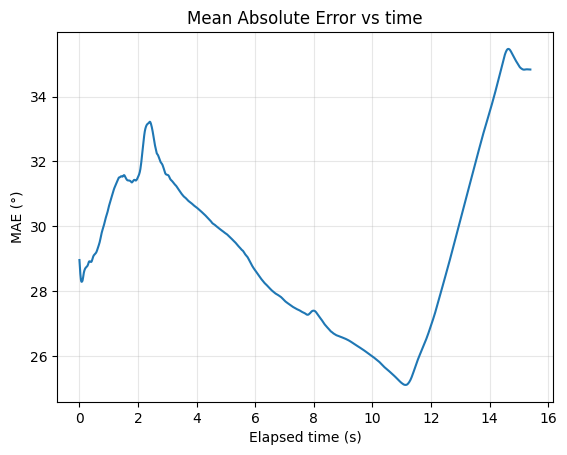

In [15]:
errors_over_time = []

for i in range(1,len(relative_time_IMU)+1):

    CV_interp = np.interp(relative_time_IMU[0:i], relative_time_CV[0:i], cv_angle_guassian_smooth[0:i])
    absolute_error = sum((abs(CV_interp - angles[0:i])))
    MAE = absolute_error / i
    errors_over_time.append(MAE)

plt.plot(relative_time_IMU, errors_over_time)
plt.title("Mean Absolute Error vs time")
plt.xlabel("Elapsed time (s)")
plt.ylabel("MAE (°)")
plt.grid(alpha=0.3)
plt.show()  

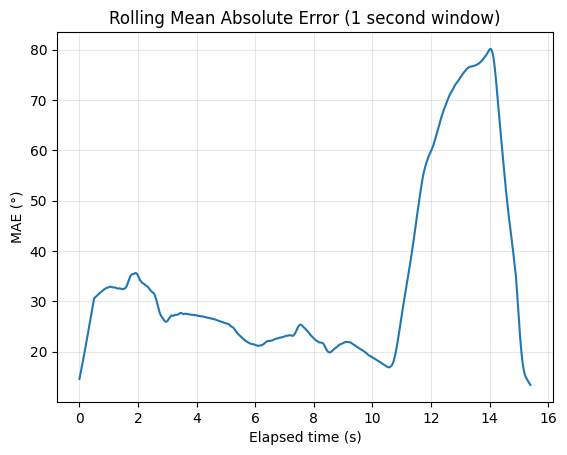

In [16]:
#rolling MAE window
cv_at_imu = np.interp(relative_time_IMU, relative_time_CV, cv_angle_guassian_smooth)

erors = []
window = 100
half = window // 2
for i in range(0, len(relative_time_IMU)):
    if i - half < 0:
        total_error = sum(abs(cv_at_imu[0: i + half] - angles[0 : i + half]))
        mae = total_error / window
        erors.append(mae)
    else:
        total_error = sum(abs(cv_at_imu[i - half : i + half] - angles[i - half : i + half]))
        mae = total_error / window
        erors.append(mae)


plt.plot(relative_time_IMU, erors)
plt.title("Rolling Mean Absolute Error (1 second window)")
plt.xlabel("Elapsed time (s)")
plt.ylabel("MAE (°)")
plt.grid(alpha=0.3)
plt.show()

In [17]:

def calculate_angles_and_reweighted_window(angles, weighted_window, lower_bound, upper_bound):
    weighted_average = []
    angles_to_avg = angles[lower_bound: upper_bound]
    
    if lower_bound == 0:
        for missing_angle in range(0,len(weighted_window)- len(angles_to_avg)):
                angles_to_avg.insert(0,angles[0])
    else:
        for missing_angle in range(0,len(weighted_window)- len(angles_to_avg)):
                angles_to_avg.append(angles[-1])
    
    for j in range(0, len(angles_to_avg)):
                weighted_angle = angles_to_avg[j] * weighted_window[j]
                weighted_average.append(weighted_angle)

    return weighted_average

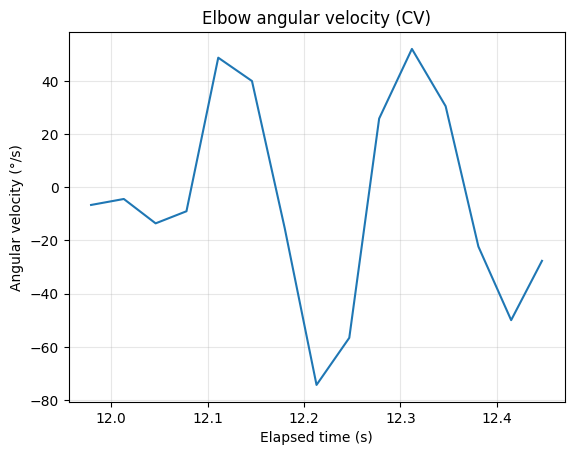

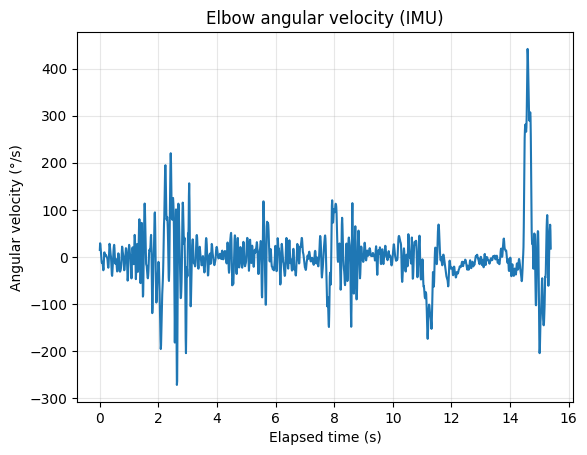

In [18]:


def weighted_convolution(angles, weighted_window):
    
    smoothed_signal = []
    half = len(weighted_window) // 2 #go up and down by half to keep convolution in the middle

    for i in range(0, len(angles)):

        #check if out of bounds (below 0)
        if i - half < 0: 
          
            weighted_average = calculate_angles_and_reweighted_window(angles,weighted_window, 0, i + half + 1)
            smoothed_signal.append(sum(weighted_average))
        
        #check if out of bound (above last index)
        elif i + half  > len(angles) - 1:
            
            weighted_average = calculate_angles_and_reweighted_window(angles, weighted_window, i - half, i + half + 1)
            smoothed_signal.append(sum(weighted_average))
        
        else:

            weighted_average = calculate_angles_and_reweighted_window(angles, weighted_window, i - half, i + half + 1)
            smoothed_signal.append(sum(weighted_average))
    
    return smoothed_signal


cv_angle_velocity = weighted_convolution(cv_angle_guassian_smooth, [-1,0,1])
dt = np.array(relative_time_CV)  # seconds
vel_CV = np.array(cv_angle_velocity) / (dt[2:] - dt[:-2]).mean()

plt.plot(relative_time_CV, vel_CV)
plt.title("Elbow angular velocity (CV)")
plt.xlabel("Elapsed time (s)")
plt.ylabel("Angular velocity (°/s)")
plt.grid(alpha=0.3)
plt.show()

IMU_angle_velocity = weighted_convolution(angles, [-1,0,1])
dt = np.array(relative_time_IMU)  # seconds
vel_IMU = np.array(IMU_angle_velocity) / (dt[2:] - dt[:-2]).mean()

plt.plot(relative_time_IMU, vel_IMU)
plt.title("Elbow angular velocity (IMU)")
plt.xlabel("Elapsed time (s)")
plt.ylabel("Angular velocity (°/s)")
plt.grid(alpha=0.3)
plt.show()